# NLP Recommender System for Trip Advisor: Data Analysis and System Creation


## Table of Contents
---
- [Reading Data](#Reading-Data)
- [Data Cleaning](#Data-Cleaning)
- [Data Visualization](#Data-Visualization)
  - [Word Clouds](#Word-Clouds)
  - [Most Frequent Words](#Most-Frequent-Words)
- [Model Preparation](#Model-Preparation)
  - [Establishing a Baseline](#Establishing-a-Baseline)
- [NLP System](#NLP-System)
  - [TF-IDF Vectorization](#TF-IDF-Vectorization)
  - [Count Vectorization](#Count-Vectorization)
  - [Bi Grams](#Bi-Grams)
- [Discussion and Recommendations](#Discussion-and-Recommendations)

## Reading Data

We first import the necessary libraries necessary for data cleaning, modeling, and visualization.

In [1]:
# !pip install nltk
# !pip download spacy
# !pip install prettytable
# !pip install tensorflow-text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


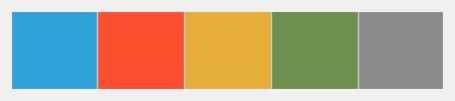

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]
sns.set_palette(five_thirty_eight)
sns.palplot(sns.color_palette())
import plotly.graph_objects as go
import plotly.express as px

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Download stopwords from nltk
nltk.download('stopwords')

# Download the punkt tokenizer
nltk.download('punkt')

# Download the WordNet resource
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import compute_sample_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics.pairwise import cosine_similarity

from prettytable import PrettyTable

# For word clouds
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# For BERT
!pip install tensorflow-text
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
import tensorflow_text
import sklearn.metrics as metrics

Next, we summarize what we found from scraping Trip Advisor.

In [3]:
travel_df = pd.read_csv('all_things_to_do.csv')
print('There are {} rows and {} columns in our dataset.'.format(travel_df.shape[0],travel_df.shape[1]))

There are 36288 rows and 2 columns in our dataset.


In [4]:
travel_df.sample(10)

Text                Location
7705                  Moskva - Moi Lyubimy Knizhny          Moscow, Russia
25553                                  Hide N Seek         Bali, Indonesia
5296                               Shiatsu am Alex         Berlin, Germany
20438                                  Wattle Park   Melbourne, Austrailia
13813                              Siena Golf Club       Las Vegas, Nevada
962                     Repete Cocktail & Cafe Bar  Prague, Czech Republic
28785                                Flow Bookshop        Hong Kong, China
14803                     Statue de Paul Deroulede           Paris, France
7865                                 TopStretching          Moscow, Russia
3398   Kunj Sarees (Rajasthani Traditional Sarees)        Rajasthan, India

In [5]:
travel_df.describe()

Text     Location
count              36288        36288
unique             34355           20
top     The Barber's Spa  Rome, Italy
freq                  12         3090

We are can that there are `34,355` unique things to do at `20` locations. We will now clean our travel dataset.

## Data Cleaning
Let's first check for null values.

In [6]:
travel_df.isna().sum()

Text        0
Location    0
dtype: int64

There aren't any null values (as we scrapped valid destinations from Trip Advisor). However, we can see that there are a fair amount of locations with duplicated text. We will remove these.

In [7]:
travel_df = travel_df.drop_duplicates()

We then plot the associated locations to see how many things to do we found at individual locations.

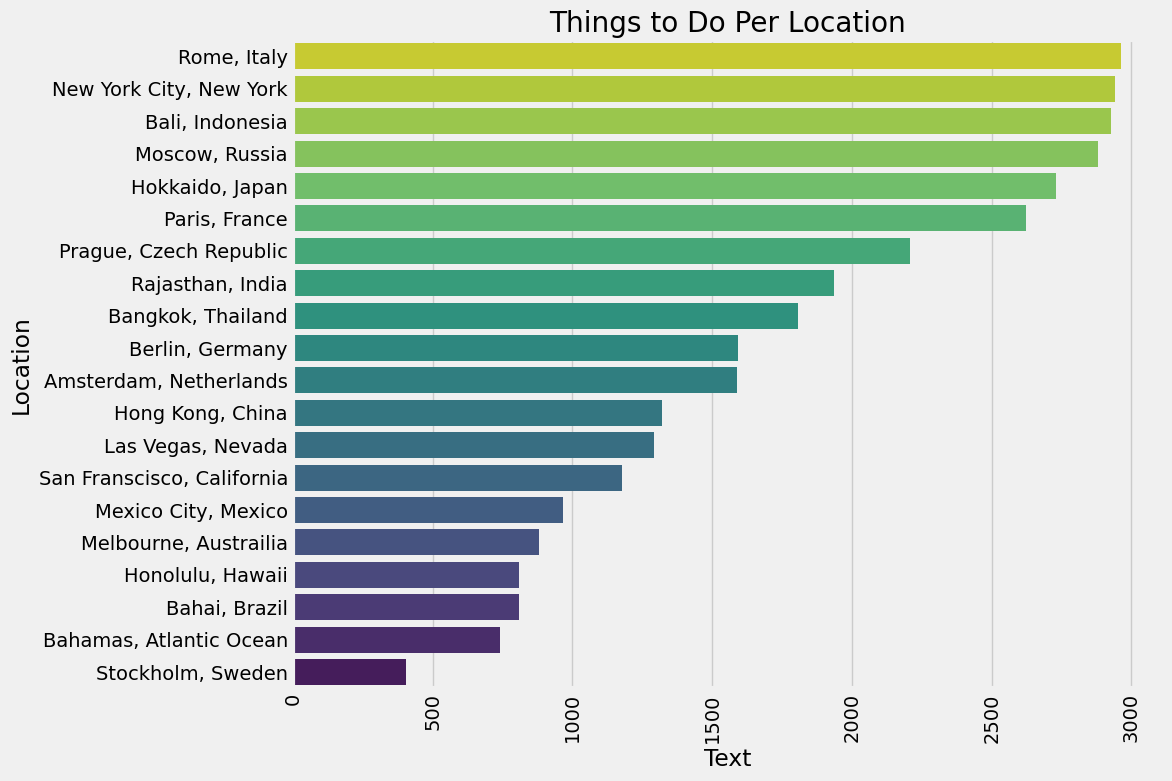

In [8]:
def plot_things_to_do_per_location(travel_df):
    """
    Plot the number of things to do per location using a bar chart.

    Parameters:
    - travel_df (pd.DataFrame): DataFrame containing the travel data.

    Returns:
    None
    """
    # Group by 'Location' and count occurrences
    locations = travel_df.groupby('Location').count()

    # Create a bar plot
    plt.figure(figsize=(10, 8))

    # Sort the locations by the number of text in descending order
    sorted_cities = locations.sort_values(by='Text', ascending=False)

    # Automatically generate a color palette based on the number of unique locations
    num_locations = len(sorted_cities)
    palette = sns.color_palette('viridis', num_locations)

    # Use seaborn barplot with the automatically generated color palette
    sns.barplot(x='Text', y='Location', data=sorted_cities, palette=palette, hue='Text', dodge=False, legend=False)

    # Set plot title and customize axis labels
    plt.title('Things to Do Per Location')
    plt.xticks(rotation=90)

    # Display the plot
    plt.show()


plot_things_to_do_per_location(travel_df)


Next, we will clean the text in things to do for downstream processing.

In [9]:
def clean_text_column(df, column_name):
    """
    Clean the specified text column in the DataFrame using NLTK for tokenization,
    stopword removal, lemmatization, and punctuation removal.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the text column.
    - column_name (str): Name of the text column to be cleaned.

    Returns:
    None
    """
    # Ensure the specified column exists in the DataFrame
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return

    # Define NLTK objects for stop words and lemmatization
    stop_words_ = set(stopwords.words('english'))
    wn = WordNetLemmatizer()

    def black_txt(token):
        # Check if the token is not a stop word, not a punctuation, and has a length greater than 2
        return token not in stop_words_ and token not in list(string.punctuation) and len(token) > 2

    def clean_txt(text):
        # Remove apostrophes, digits, non-word characters, and replace 'nbsp'
        text = re.sub("'", "", text)
        text = re.sub("(\\d|\\W)+", " ", text)
        text = text.replace("nbsp", "")

        # Tokenize, lemmatize, and filter based on defined conditions
        clean_text = [wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]

        return " ".join(clean_text)

    # Apply the cleaning function to the specified column
    df[column_name] = df[column_name].apply(clean_txt)

# Apply the clean text function to the "Things to Do"
clean_text_column(travel_df, 'Text')

We will now move onto visualizing our travel data.

## Data Visualization
Since our travel locations have thousands of words, let's make word clouds to display common text associated with travel.

### Word Clouds
Below, we create a function for generating word clouds from the raw text scraped by all the travel destinations.

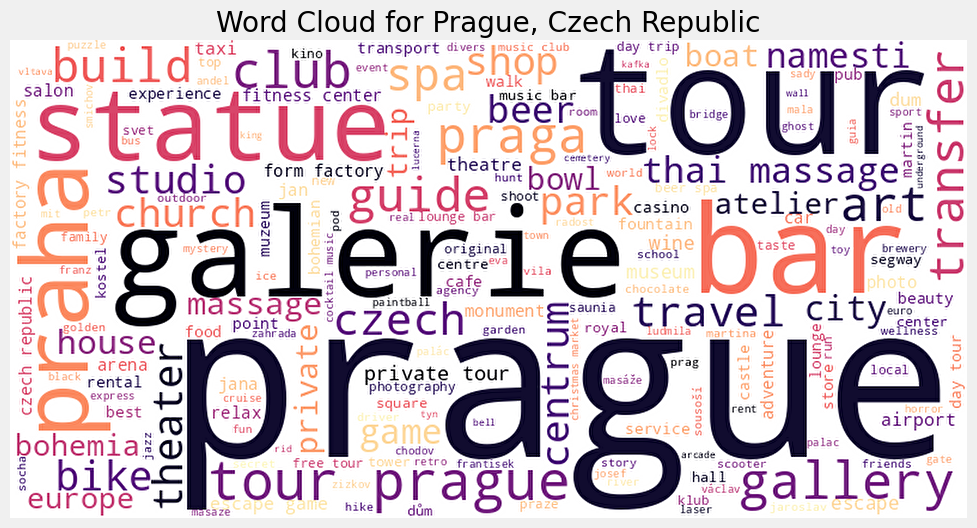

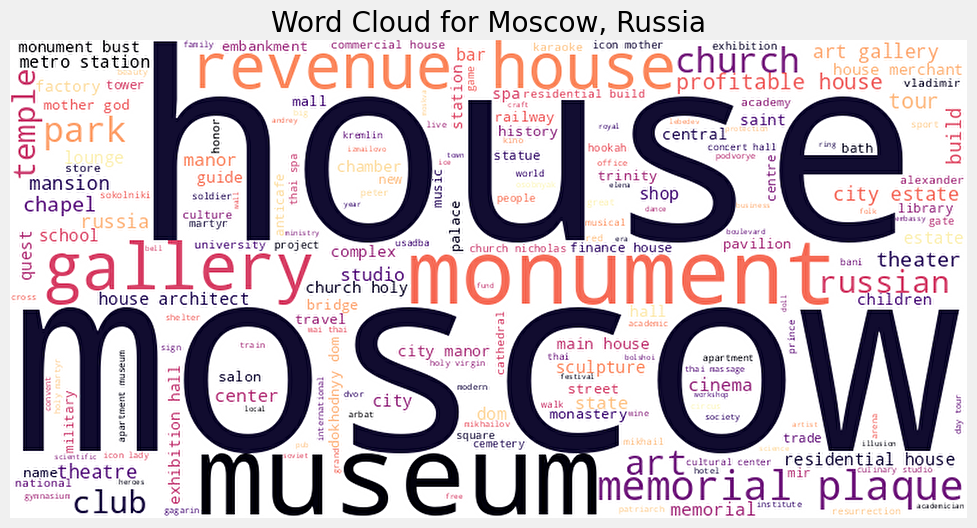

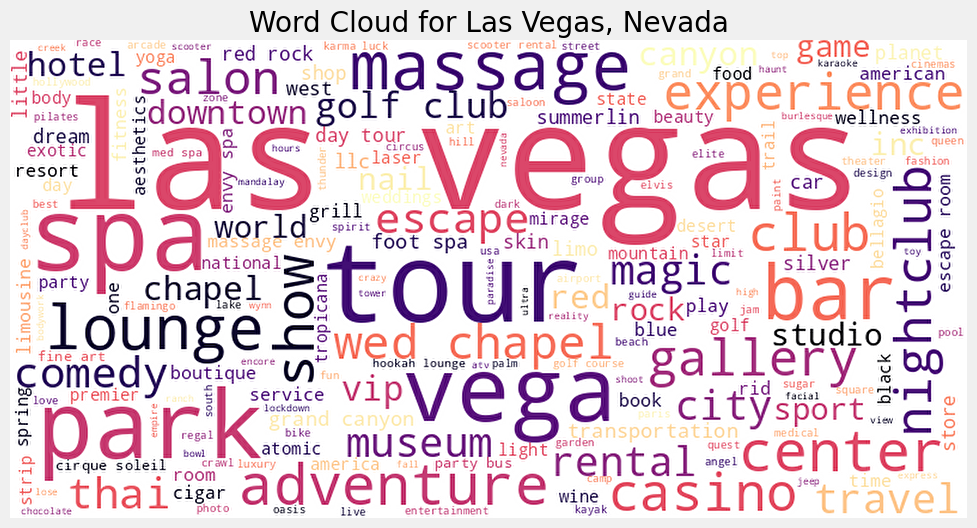

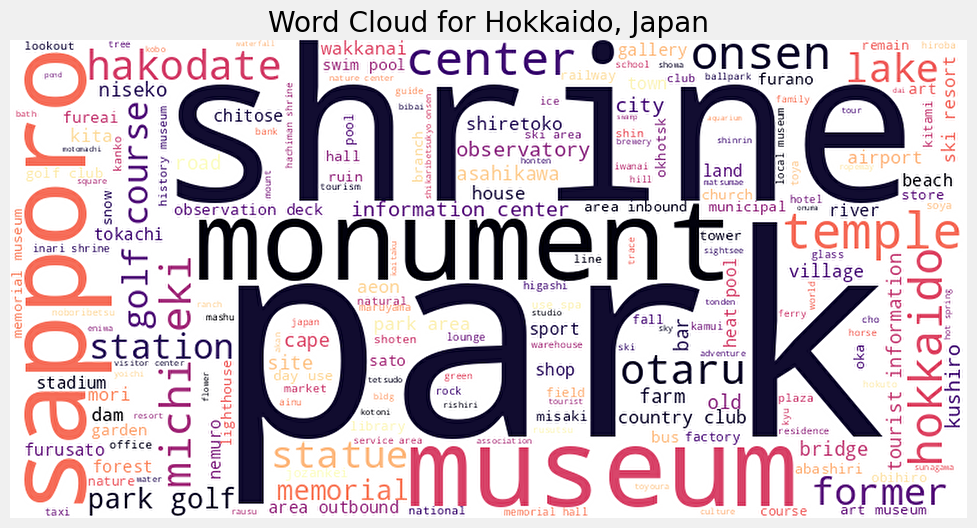

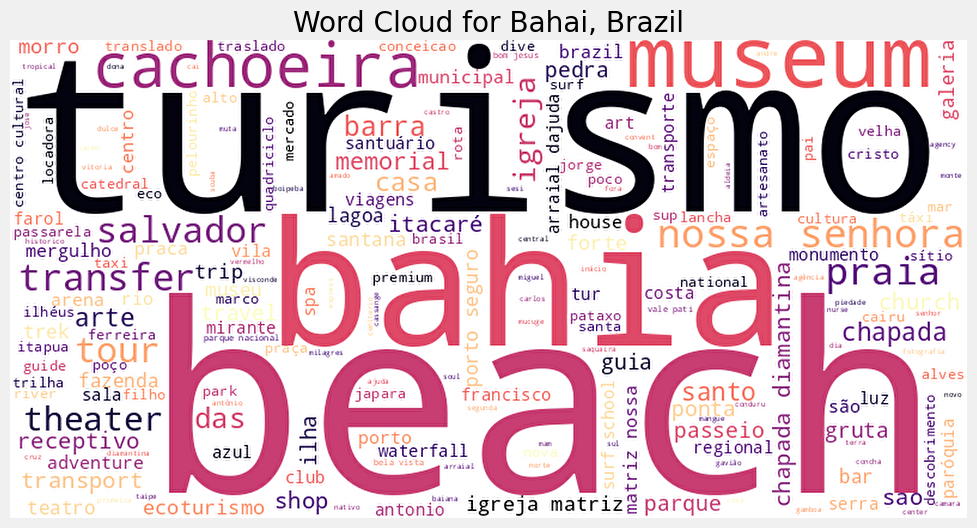

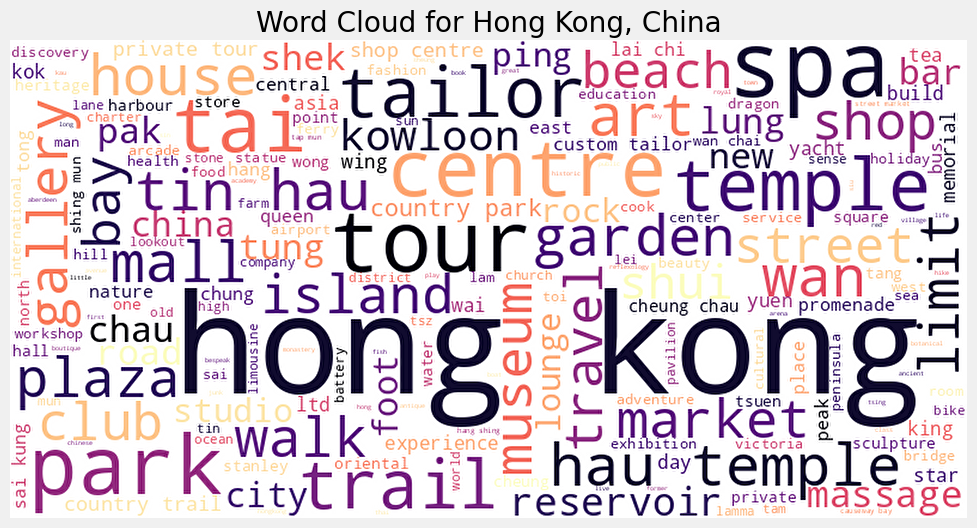

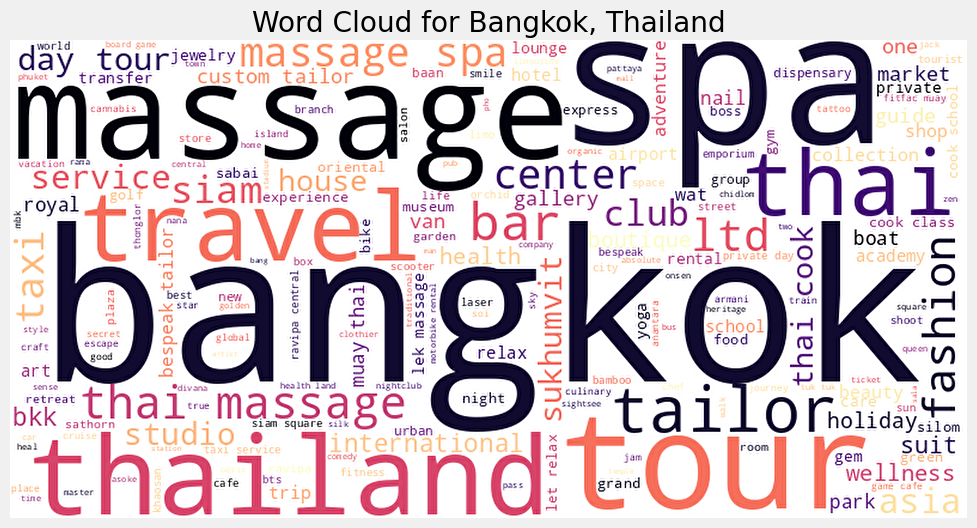

In [10]:
def generate_wordcloud(data, location):
    """
    Generate and display a word cloud for a specific location in the given data.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the travel data.
    - location (str): Name of the location for which to generate the word cloud.

    Returns:
    None
    """
    # Extract text data for the specified location
    location_text = " ".join(text for text in data[data['Location'] == location]['Text'])

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap="magma", random_state=42).generate(location_text)

    # Plot the word cloud
    plt.figure(figsize=[11, 11])
    plt.title(f"Word Cloud for {location}")
    plt.imshow(wordcloud, interpolation="sinc")
    plt.axis("off")
    plt.show()
    plt.close()

# Loop through unique locations in the 'Location' column of travel_df with a step of 3
for i in range(0, len(travel_df['Location'].unique()), 3):
    # Get the current location
    location = travel_df['Location'].unique()[i]

    # Call generate_wordcloud function for the current location
    generate_wordcloud(travel_df, location)

    # Print two empty lines
    print("\n\n")

### Most Frequent Words
Next, we analyze the most frequent words in things to do across all locations scraped from Trip Advisor.

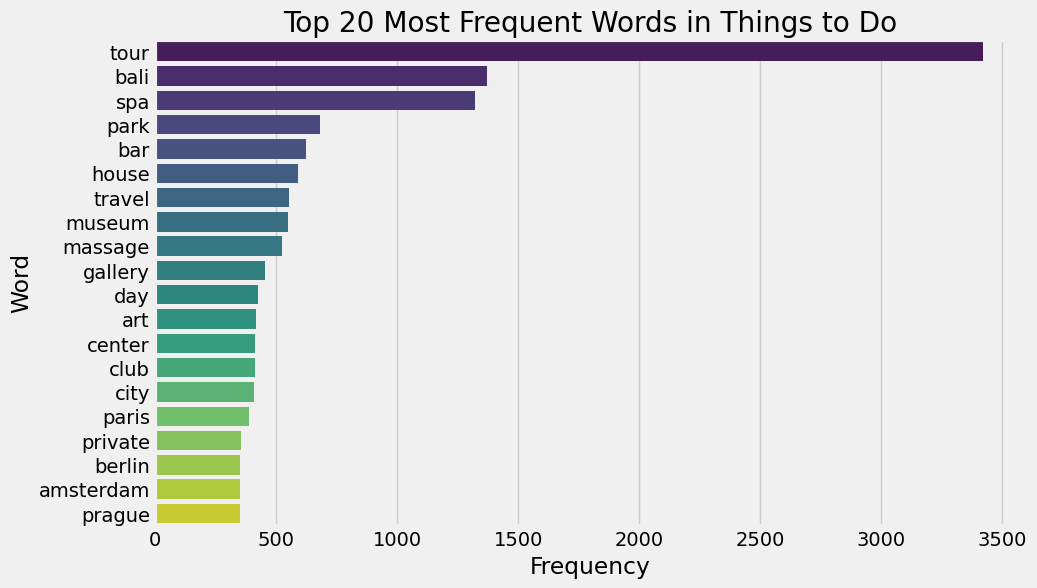

In [11]:
def plot_most_frequent_words(dataframe, column_name, num_words=10):
    """
    Find the most frequent words in a text column of a DataFrame and plot them in a Seaborn barplot.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the text column.
    - column_name (str): The name of the text column.
    - num_words (int): Number of most frequent words to display. Default is 10.

    Returns:
    None
    """
    # Combine all text in the specified column
    all_text = ' '.join(dataframe[column_name].dropna().astype(str))

    # Tokenize the text
    tokens = word_tokenize(all_text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

    # Calculate frequency distribution
    freq_dist = FreqDist(tokens)

    # Get the top N most frequent words and their frequencies
    top_words, frequencies = zip(*freq_dist.most_common(num_words))

    # Create a DataFrame for plotting
    plot_data = pd.DataFrame({'Word': top_words, 'Frequency': frequencies})

    # Plot using Seaborn barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Frequency', y='Word', data=plot_data, palette='viridis', hue='Word', dodge=False, legend=False)
    plt.title(f"Top {num_words} Most Frequent Words in Things to Do")
    plt.xlabel("Frequency")
    plt.ylabel("Word")
    plt.show()


plot_most_frequent_words(travel_df, 'Text', num_words=20)

We can see that `tour`, `bali`, `spa`, `park`, and `bar` are the five most frequent words. This makes sense as these five words are common activities associated with travel.

## Model Preparation

Before we prepare our model, we will first establish a baseline.

### Establing a baseline

In our case, the baseline will be a [Naive Bayes estimator](https://towardsdatascience.com/all-about-naive-bayes-8e13cef044cf) which is a recommended estimator for text classification problems with large datasets. We first split up our dataset into Train and Test.

In [12]:
X = travel_df['Text']
y = travel_df['Location']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)
X_train.shape, X_test.shape

((25952,), (8651,))

We then create several helper functions to summarize statistical information about our models.

In [13]:
def compute_sample_weights(y):
    """
    Compute sample weights based on class weights for handling class imbalance.

    Parameters:
    - y (array-like): Target labels.

    Returns:
    - array-like: Sample weights.
    """
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    sample_weights = compute_sample_weight(class_weight={cls: weight for cls, weight in zip(np.unique(y), class_weights)}, y=y)
    return sample_weights

def evaluate_model(model, X, y, label='Training'):
    """
    Evaluate a model on given data and print accuracy, precision, recall, F1-score, and classification report.

    Parameters:
    - model: Trained model.
    - X (array-like): Data.
    - y (array-like): Target labels.
    - label (str): Label for printing.

    Returns:
    None
    """
    y_preds = model.predict(X)
    print(f'------------- {label} Statistics -------------')
    print(f'{label} Accuracy: {accuracy_score(y, y_preds)}')
    print(f'{label} Precision: {precision_score(y, y_preds, average="weighted")}')
    print(f'{label} Recall: {recall_score(y, y_preds, average="weighted")}')
    print(f'{label} F1: {f1_score(y, y_preds, average="weighted")}')
    print()

In [14]:
def train_and_evaluate_multinomial_model(X_train, y_train, X_test, y_test, vectorizer):
    """
    Train and evaluate a Complement Naive Bayes model on the training and testing data.

    Parameters:
    - X_train (array-like): Training text data.
    - y_train (array-like): Training labels.
    - X_test (array-like): Testing text data.
    - y_test (array-like): Testing labels.
    - vectorizer: Text vectorizer.

    Returns:
    None
    """
    X_train_baseline = vectorizer.fit_transform(X_train)
    X_test_baseline = vectorizer.transform(X_test)

    sample_weights_train = compute_sample_weights(y_train)
    sample_weights_test = compute_sample_weights(y_test)

    model = MultinomialNB()
    model.fit(X_train_baseline, y_train, sample_weights_train)

    evaluate_model(model, X_train_baseline, y_train, label='Training')
    evaluate_model(model, X_test_baseline, y_test, label='Test')

We then test our Naive Bayes Multinomial model.

In [15]:
vectorizer = TfidfVectorizer(analyzer='word', decode_error='ignore')
train_and_evaluate_multinomial_model(X_train, y_train, X_test, y_test, vectorizer)

------------- Training Statistics -------------
Training Accuracy: 0.8223643649815043
Training Precision: 0.8404067559054572
Training Recall: 0.8223643649815043
Training F1: 0.8245963453974384

------------- Test Statistics -------------
Test Accuracy: 0.5427118252225176
Test Precision: 0.6012720611196315
Test Recall: 0.5427118252225176
Test F1: 0.5571790288392344



We can improve our baseline model by recognizing that we have class imbalances (due to scraping more text from specific locations in Trip Advisor). Instead of using [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html), we can apply [Complement Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html#sklearn.naive_bayes.ComplementNB). Complement Naive Bayes is an adaptation of Multinomial Naive Bayes where the complement of each class is used to calculate the model weights. So, it is suitable for imbalanced data sets and often outperforms the Multinomial Naive Bayes on text classification tasks.

In [16]:
def train_and_evaluate_complement_multinomial_model(X_train, y_train, X_test, y_test, vectorizer):
    """
    Train and evaluate a Complement Naive Bayes model on the training and testing data.

    Parameters:
    - X_train (array-like): Training text data.
    - y_train (array-like): Training labels.
    - X_test (array-like): Testing text data.
    - y_test (array-like): Testing labels.
    - vectorizer: Text vectorizer.

    Returns:
    None
    """
    X_train_baseline = vectorizer.fit_transform(X_train)
    X_test_baseline = vectorizer.transform(X_test)

    model = ComplementNB()
    model.fit(X_train_baseline, y_train)

    evaluate_model(model, X_train_baseline, y_train, label='Training')
    evaluate_model(model, X_test_baseline, y_test, label='Test')

Let's test our improved model with the Complement Naive Bayes.

In [17]:
vectorizer = TfidfVectorizer(analyzer='word', decode_error='ignore')
train_and_evaluate_complement_multinomial_model(X_train, y_train, X_test, y_test, vectorizer)

------------- Training Statistics -------------
Training Accuracy: 0.8923782367447596
Training Precision: 0.8935969225819989
Training Recall: 0.8923782367447596
Training F1: 0.8917380819045935

------------- Test Statistics -------------
Test Accuracy: 0.5659461333949832
Test Precision: 0.6051110299923865
Test Recall: 0.5659461333949832
Test F1: 0.5728928203720127



We see that we get reasonable performance results with the Complement Naive Bayes algorithm. Can we get better performance results with a different algorithm?

## NLP Recommender Systems

### Count Vectorization

As a first comparison, we will analyze performance results using Count Vectorization instead of TD-IDF Vectorization.

In [18]:
vectorizer = CountVectorizer(analyzer='word', decode_error='ignore')
train_and_evaluate_complement_multinomial_model(X_train, y_train, X_test, y_test, vectorizer)

------------- Training Statistics -------------
Training Accuracy: 0.875308261405672
Training Precision: 0.8772203164732865
Training Recall: 0.875308261405672
Training F1: 0.8745976244597562

------------- Test Statistics -------------
Test Accuracy: 0.5666396948329673
Test Precision: 0.6062204164050777
Test Recall: 0.5666396948329673
Test F1: 0.5730614183446714



Next, we will try Bi-Grams aginst TD-IDF vectorization and Count Vectorization.

### Bi-Grams

Bi-Grams with TD-IDF Vectorization.

In [19]:
vectorizer = TfidfVectorizer(analyzer='word', decode_error='ignore', ngram_range=(2,2))
train_and_evaluate_complement_multinomial_model(X_train, y_train, X_test, y_test, vectorizer)

------------- Training Statistics -------------
Training Accuracy: 0.8798551171393342
Training Precision: 0.9569233408741381
Training Recall: 0.8798551171393342
Training F1: 0.9054397622468902

------------- Test Statistics -------------
Test Accuracy: 0.2778869494856086
Test Precision: 0.6638952371383969
Test Recall: 0.2778869494856086
Test F1: 0.34576670251031005



Bi-Grams with Count Vectorization.

In [20]:
vectorizer = CountVectorizer(analyzer='word', decode_error='ignore', ngram_range=(2,2))
train_and_evaluate_complement_multinomial_model(X_train, y_train, X_test, y_test, vectorizer)

------------- Training Statistics -------------
Training Accuracy: 0.876040382244143
Training Precision: 0.9529357979775845
Training Recall: 0.876040382244143
Training F1: 0.901562239885262

------------- Test Statistics -------------
Test Accuracy: 0.2778869494856086
Test Precision: 0.6658833977313352
Test Recall: 0.2778869494856086
Test F1: 0.34657964776595107



We now combine all of our results into a table for visualization.

In [21]:
def evaluate_model_metrics(model, X, y, label='Training'):
    """
    Evaluate a model on given data and return accuracy, precision, recall, and F1-score.

    Parameters:
    - model: Trained model.
    - X (array-like): Data.
    - y (array-like): Target labels.
    - label (str): Label for printing.

    Returns:
    dict: Dictionary containing evaluation metrics.
    """
    y_preds = model.predict(X)
    metrics = {
        'Accuracy': accuracy_score(y, y_preds),
        'Precision': precision_score(y, y_preds, average='weighted'),
        'Recall': recall_score(y, y_preds, average='weighted'),
        'F1': f1_score(y, y_preds, average='weighted')
    }
    return metrics

def train_and_evaluate_complement_multinomial_table(X_train, y_train, X_test, y_test, vectorizer):
    """
    Train and evaluate a Complement Naive Bayes model on the training and testing data.

    Parameters:
    - X_train (array-like): Training text data.
    - y_train (array-like): Training labels.
    - X_test (array-like): Testing text data.
    - y_test (array-like): Testing labels.
    - vectorizer: Text vectorizer.

    Returns:
    PrettyTable: Table containing evaluation results.
    """
    X_train_baseline = vectorizer.fit_transform(X_train)
    X_test_baseline = vectorizer.transform(X_test)

    model = ComplementNB()
    model.fit(X_train_baseline, y_train)

    train_results = evaluate_model_metrics(model, X_train_baseline, y_train, label='Training')
    test_results = evaluate_model_metrics(model, X_test_baseline, y_test, label='Test')

    # Create a PrettyTable
    table = PrettyTable()
    table.field_names = ["Metric", "Training", "Test"]

    # Add rows to the table
    metrics = ["Accuracy", "Precision", "Recall", "F1"]
    for metric in metrics:
        table.add_row([
            metric,
            f"{train_results[metric]:.2%}",
            f"{test_results[metric]:.2%}"
        ])

    return table

# Example usage:
vectorizer1 = TfidfVectorizer(analyzer='word', decode_error='ignore')
result1 = train_and_evaluate_complement_multinomial_table(X_train, y_train, X_test, y_test, vectorizer1)

vectorizer2 = CountVectorizer(analyzer='word', decode_error='ignore')
result2 = train_and_evaluate_complement_multinomial_table(X_train, y_train, X_test, y_test, vectorizer2)

vectorizer3 = TfidfVectorizer(analyzer='word', decode_error='ignore', ngram_range=(2,2))
result3 = train_and_evaluate_complement_multinomial_table(X_train, y_train, X_test, y_test, vectorizer3)

vectorizer4 = CountVectorizer(analyzer='word', decode_error='ignore', ngram_range=(2,2))
result4 = train_and_evaluate_complement_multinomial_table(X_train, y_train, X_test, y_test, vectorizer4)

# Print the tables
print("Vectorizer 1 (TfidfVectorizer):")
print(result1)

print("\nVectorizer 2 (CountVectorizer):")
print(result2)

print("\nVectorizer 3 (TfidfVectorizer, ngram_range=(2,2)):")
print(result3)

print("\nVectorizer 4 (CountVectorizer, ngram_range=(2,2)):")
print(result4)


Vectorizer 1 (TfidfVectorizer):
+-----------+----------+--------+
|   Metric  | Training |  Test  |
+-----------+----------+--------+
|  Accuracy |  89.24%  | 56.59% |
| Precision |  89.36%  | 60.51% |
|   Recall  |  89.24%  | 56.59% |
|     F1    |  89.17%  | 57.29% |
+-----------+----------+--------+

Vectorizer 2 (CountVectorizer):
+-----------+----------+--------+
|   Metric  | Training |  Test  |
+-----------+----------+--------+
|  Accuracy |  87.53%  | 56.66% |
| Precision |  87.72%  | 60.62% |
|   Recall  |  87.53%  | 56.66% |
|     F1    |  87.46%  | 57.31% |
+-----------+----------+--------+

Vectorizer 3 (TfidfVectorizer, ngram_range=(2,2)):
+-----------+----------+--------+
|   Metric  | Training |  Test  |
+-----------+----------+--------+
|  Accuracy |  87.99%  | 27.79% |
| Precision |  95.69%  | 66.39% |
|   Recall  |  87.99%  | 27.79% |
|     F1    |  90.54%  | 34.58% |
+-----------+----------+--------+

Vectorizer 4 (CountVectorizer, ngram_range=(2,2)):
+-----------+--

## NLP Systems

### Cosine Similarity using TD-IDF

In [40]:
text_to_predict = "I want to eat a lot of chocolate and pizza."
vectorizer = TfidfVectorizer(analyzer='word', decode_error='ignore')
X_train_baseline = vectorizer.fit_transform(X_train)
travel_tfidf = vectorizer.transform([text_to_predict])  # Wrap the text in a list

cos_similarity_tfidf = [cosine_similarity(travel_tfidf, x) for x in X_train_baseline]
cos_similarity_tfidf_list = list(cos_similarity_tfidf)


Create a function to find the top N recommendations by score.

In [41]:
def get_recommendation(text_to_predict, df_all, scores, top_k=10):
    """
    Generate recommendation DataFrame based on top scores, DataFrame, and text.

    Parameters:
    - text_to_predict (str): The user's input text.
    - df_all (pd.DataFrame): DataFrame containing additional information (e.g., locations).
    - scores (list): List of similarity scores.
    - top_k (int): Number of top recommendations to retrieve (default is 10).

    Returns:
    - pd.DataFrame: DataFrame containing recommendations.
    """
    # Get top-k indices based on scores
    top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_k]

    recommendation = pd.DataFrame(columns=['Text', 'Location', 'Score'])

    for i, index in enumerate(top_indices):
        recommendation.at[i, 'Text'] = text_to_predict
        recommendation.at[i, 'Location'] = df_all['Location'].iloc[index]
        recommendation.at[i, 'Score'] = scores[index]

    return recommendation

Test the function.

In [42]:
# Generate recommendation using the get_recommendation function
list_scores = list_scores = [cos_similarity_tfidf_list[i][0][0] for i in range(len(cos_similarity_tfidf_list))]
recommendation_df = get_recommendation(text_to_predict, travel_df, list_scores)
recommendation_df

Text                 Location  \
0  I want to eat a lot of chocolate and pizza.          Hokkaido, Japan   
1  I want to eat a lot of chocolate and pizza.  New York City, New York   
2  I want to eat a lot of chocolate and pizza.            Paris, France   
3  I want to eat a lot of chocolate and pizza.           Moscow, Russia   
4  I want to eat a lot of chocolate and pizza.          Hokkaido, Japan   
5  I want to eat a lot of chocolate and pizza.            Paris, France   
6  I want to eat a lot of chocolate and pizza.  New York City, New York   
7  I want to eat a lot of chocolate and pizza.  Bahamas, Atlantic Ocean   
8  I want to eat a lot of chocolate and pizza.  New York City, New York   
9  I want to eat a lot of chocolate and pizza.          Hokkaido, Japan   

      Score  
0  0.409345  
1   0.38607  
2  0.349227  
3  0.334358  
4  0.325949  
5  0.310711  
6  0.308867  
7  0.303729  
8  0.298307  
9  0.291153

## Cosine Similarity using Count Vectorizer

In [43]:
text_to_predict = "I want to eat a lot of chocolate and pizza."
vectorizer = CountVectorizer(analyzer='word', decode_error='ignore')
X_train_baseline = vectorizer.fit_transform(X_train)
travel_count_vectorizer = vectorizer.transform([text_to_predict])  # Wrap the text in a list

cos_similarity_count_vectorizer = map(lambda x: cosine_similarity(travel_count_vectorizer, x),X_train_baseline)
cos_similarity_count_vectorizer_list = list(cos_similarity_count_vectorizer)

Test the function.

In [44]:
# Generate recommendation using the get_recommendation function
list_scores = list_scores = [cos_similarity_count_vectorizer_list[i][0][0] for i in range(len(cos_similarity_count_vectorizer_list))]
recommendation_df = get_recommendation(text_to_predict, travel_df, list_scores)
recommendation_df

Text                 Location  \
0  I want to eat a lot of chocolate and pizza.  New York City, New York   
1  I want to eat a lot of chocolate and pizza.   Prague, Czech Republic   
2  I want to eat a lot of chocolate and pizza.         Rajasthan, India   
3  I want to eat a lot of chocolate and pizza.         Rajasthan, India   
4  I want to eat a lot of chocolate and pizza.         Rajasthan, India   
5  I want to eat a lot of chocolate and pizza.          Berlin, Germany   
6  I want to eat a lot of chocolate and pizza.        Las Vegas, Nevada   
7  I want to eat a lot of chocolate and pizza.            Paris, France   
8  I want to eat a lot of chocolate and pizza.            Paris, France   
9  I want to eat a lot of chocolate and pizza.          Hokkaido, Japan   

      Score  
0  0.447214  
1  0.316228  
2  0.316228  
3  0.316228  
4  0.316228  
5  0.316228  
6  0.316228  
7  0.316228  
8  0.316228  
9  0.316228

## Try KNN

In [70]:
from sklearn.neighbors import NearestNeighbors

text_to_predict = "I want to eat a lot of chocolate and pizza."
n_neighbors = 10
KNN = NearestNeighbors(n_neighbors=n_neighbors, p=2)
KNN.fit(X_train_baseline)
NNs = KNN.kneighbors(travel_tfidf, n_neighbors=n_neighbors, return_distance=True)

In [71]:
NNs[0][0][1:]

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [72]:
top = NNs[1][0][1:]
index_score = NNs[0][0][1:]

get_recommendation(text_to_predict, travel_df, index_score)

Text                Location Score
0  I want to eat a lot of chocolate and pizza.  Prague, Czech Republic   1.0
1  I want to eat a lot of chocolate and pizza.  Prague, Czech Republic   1.0
2  I want to eat a lot of chocolate and pizza.  Prague, Czech Republic   1.0
3  I want to eat a lot of chocolate and pizza.  Prague, Czech Republic   1.0
4  I want to eat a lot of chocolate and pizza.  Prague, Czech Republic   1.0
5  I want to eat a lot of chocolate and pizza.  Prague, Czech Republic   1.0
6  I want to eat a lot of chocolate and pizza.  Prague, Czech Republic   1.0
7  I want to eat a lot of chocolate and pizza.  Prague, Czech Republic   1.0
8  I want to eat a lot of chocolate and pizza.  Prague, Czech Republic   1.0

### BERT



Preprocessing Steps


In [101]:
df_yt = pd.read_csv('all_things_to_do.csv')
df_yt = df_yt.drop_duplicates(subset = ['Text'])
df_yt = df_yt[['Text', 'Location']]
df_yt.columns = ['Text', 'Location']
df_yt['cleaned_text'] = df_yt['Text'].apply(lambda x: x.lower())
df_yt['cleaned_text'] = df_yt['cleaned_text'].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))

In [102]:
df_yt.head()

Text                Location  \
0  Film Legends Experience Museum Prague  Prague, Czech Republic   
1                       St. Giles Church  Prague, Czech Republic   
2                   Church of St Ludmila  Prague, Czech Republic   
3                                Josefov  Prague, Czech Republic   
4        DOX Centre for Contemporary Art  Prague, Czech Republic   

                            cleaned_text  
0  film legends experience museum prague  
1                        st giles church  
2                   church of st ludmila  
3                                josefov  
4        dox centre for contemporary art



small_bert pretrained embeddings


In [103]:
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1", trainable=True)

def get_bert_embeddings(text, preprocessor, encoder):
    text_input = tf.constant([text])
    encoder_inputs = preprocessor(text_input)
    outputs = encoder(encoder_inputs)
    return outputs['pooled_output']

# Apply the get_bert_embedding function to the 'cleaned_text' column
df_yt['encodings'] = df_yt['cleaned_text'].apply(lambda x: get_bert_embedding_2(x, preprocessor, encoder))
df_results = df_yt.sort_values(by=['similarity_score'], ascending=False)



Find similarity between interests and the encodings of the title


In [104]:
#change the text as per your interested event
def preprocess_text():
  text = "I want to eat a lot of chocolate and pizza."
  text = text.lower()
  text = re.sub('[^A-Za-z0-9]+', ' ', text)
  return text

query_text = preprocess_text()
query_encoding = get_bert_embeddings(query_text, preprocessor, encoder)

df_yt['similarity_score'] = df_yt['encodings'].apply(lambda x: metrics.pairwise.cosine_similarity(x, query_encoding)[0][0])
df_results = df_yt.sort_values(by=['similarity_score'], ascending=False)

In [106]:
df_results[:10]

Text                 Location  \
9937            Eat Like a Local      Mexico City, Mexico   
9909          Do it like a local      Mexico City, Mexico   
186              Eat With Locals   Prague, Czech Republic   
21802              The Bike Shop  Bahamas, Atlantic Ocean   
22103  The Pretty Picnic Company  Bahamas, Atlantic Ocean   
27363           The Walk Of Food   Amsterdam, Netherlands   
5951     Mijas: A Shop Of Things          Berlin, Germany   
27265            A Bigger Splash   Amsterdam, Netherlands   
13584                 The Garage        Las Vegas, Nevada   
27221         Coffeeshop Rock-it   Amsterdam, Netherlands   

                    cleaned_text  \
9937            eat like a local   
9909          do it like a local   
186              eat with locals   
21802              the bike shop   
22103  the pretty picnic company   
27363           the walk of food   
5951      mijas a shop of things   
27265            a bigger splash   
13584                 the garage   
27221         coffeeshop rock it   

                                               encodings  similarity_score  
9937   ((tf.Tensor(-0.99998915, shape=(), dtype=float...          0.963997  
9909   ((tf.Tensor(-0.99999464, shape=(), dtype=float...          0.951247  
186    ((tf.Tensor(-0.9999834, shape=(), dtype=float3...          0.946234  
21802  ((tf.Tensor(-0.99998957, shape=(), dtype=float...          0.943834  
22103  ((tf.Tensor(-0.9999913, shape=(), dtype=float3...          0.943607  
27363  ((tf.Tensor(-0.99997973, shape=(), dtype=float...          0.943547  
5951   ((tf.Tensor(-0.99999, shape=(), dtype=float32)...          0.940877  
27265  ((tf.Tensor(-0.9999813, shape=(), dtype=float3...          0.940275  
13584  ((tf.Tensor(-0.9999912, shape=(), dtype=float3...          0.936826  
27221  ((tf.Tensor(-0.99998844, shape=(), dtype=float...          0.933813